In [2]:
# https://qiita.com/maruman029/items/1de7ba0d73090bcafea0



import numpy as np
import scipy.spatial.distance as distance
import scipy.stats as stats


class knn:
    def __init__(self,k):
        self.k = k
        self._fit_X = None  # 既存データを格納 
        self.classes = None  #
        self._y = None
    def fit(self, X, label):
        # Xは元のデータ点で、shape(data_num, feature_num)
        print("original data:\n", X)
        print("label:\n", label)
        self._fit_X = X
        # ラベルデータからクラスを抽出、またラベルをindexとした配列を作成
        # self.classes[self.label_indices] == label のように復元できるのでreturn_inverseという
        self.classes, self.label_indices = np.unique(label, return_inverse=True)
        print("classes:\n", self.classes)
        print("label_indices:\n", self.label_indices)
        print("classes[label_indices]で復元されるか確認:\n", self.classes[self.label_indices])
    def neighbors(self, Y):
        # Yは予測対象のデータ点(複数可)で, shape(test_num, feature_num) 
        # 予測対象の点とデータ点の距離を求めるので、test_num * data_num だけ距離を計算する
        dist = distance.cdist(Y, self._fit_X)
        print("テストデータと元データとの距離:\n", dist)
        # distはshape(test_num, data_num) となる
        # [[1.41421356 1.11803399 2.6925824  2.23606798]   テスト点1と元データ各点との距離
        #  [3.         2.6925824  1.80277564 1.41421356]   テスト点2と元データ各点との距離
        #  [3.31662479 3.20156212 1.11803399 1.41421356]]  テスト点3と元データ各点との距離

        # 距離を測定したらk番目までに含まれるindexをもとめる
        # argpartitionはk番目までと、それ以降にデータを分ける関数
        # argsortだと距離の順位もわかるが、素のk-nnでは距離順位の情報はいらないので、argpartitionを使う
        neigh_ind = np.argpartition(dist, self.k)
        # neigh_indのshapeは(test_num, feature_num)となる
        # 上のdistでk=2でargpartitionしたときの結果
        # 例えば1行目だと index 2,1 が上位2要素になっている。上の距離をみると、0.5と1.5が相当する
        # 2行目だと index 3, 2 が上位2要素で、1.73と1.80が相当する
        #[[1 0 3 2]
        # [3 2 1 0]
        # [2 3 1 0]]
        # k番目までの情報だけを取り出す
        neigh_ind = neigh_ind[:, :self.k]
        # neigh_indのshapeは(test_num, self.k)となる
        #[[1 0]   テスト点1に近い元データ点のindexのリスト
        # [3 2]   テスト点2に近い元データ点のindexのリスト
        # [2 3]]  テスト点3に近い元データ点のindexのリスト
        return neigh_ind
    def predict(self, Y):
        # k番目までのindexを求める shape(test_num, self.k)となる
        print("test data:\n",Y)
        neigh_ind = self.neighbors(Y)
        # stats.modeでその最頻値を求める. shape(test_num, 1) . _は最頻値のカウント数
        # self.label_indices は [0 0 1 1] で、元データの各点のラベルを表す
        # neigh_indは各テスト点に近い元データのindexのリストで shape(est_num, k)となる
        # self.label_indices[neigh_ind] で、以下のような各テスト点に近いラベルのリストを取得できる
        # [[0 0]  テスト点1に近い元データ点のラベルのリスト
        #  [1 1]  テスト点2に近い元データ点のラベルのリスト
        #  [1 1]] テスト点3に近い元データ点のラベルのリスト
        # 上記データの行方向(axis=1)に対してmode(最頻値)をとり、各テスト点が属するラベルとする
        # _はカウント数
        mode, _ = stats.mode(self.label_indices[neigh_ind], axis=1)
        # modeはaxis=1で集計しているのでshape(test_num, 1)となるので、ravel(=flatten)してやる
        # [[0]
        #  [1]
        #  [1]]
        # なおnp.intpはindexに使うデータ型
        mode = np.asarray(mode.ravel(), dtype=np.intp)
        print("test dataの各ラベルindexの最頻値:\n",mode)
        # index表記からラベル名表記にする. self.classes[mode] と同じ
        result = self.classes.take(mode)
        return result

In [3]:
K = knn(k=2)
# 元のデータとラベルをセット
samples = [[0., 0., 0.], [0., .5, 0.], [1., 2., -2.5],[1., 2., -2.]]
label = ['a','a','b', 'b']
K.fit(samples, label)
# 予測したいデータ
Y = [[1., 1., 0.],[2, 2, -1],[1, 1, -3]]
p = K.predict(Y)
print("result:\n", p)

original data:
 [[0.0, 0.0, 0.0], [0.0, 0.5, 0.0], [1.0, 2.0, -2.5], [1.0, 2.0, -2.0]]
label:
 ['a', 'a', 'b', 'b']
classes:
 ['a' 'b']
label_indices:
 [0 0 1 1]
classes[label_indices]で復元されるか確認:
 ['a' 'a' 'b' 'b']
test data:
 [[1.0, 1.0, 0.0], [2, 2, -1], [1, 1, -3]]
テストデータと元データとの距離:
 [[1.41421356 1.11803399 2.6925824  2.23606798]
 [3.         2.6925824  1.80277564 1.41421356]
 [3.31662479 3.20156212 1.11803399 1.41421356]]
test dataの各ラベルindexの最頻値:
 [0 1 1]
result:
 ['a' 'b' 'b']


In [4]:
# https://qiita.com/renesisu727/items/e5191a97d3f16a14ebd0


## 分類問題の実装 ##

from sklearn.datasets import load_iris
import pandas as pd

iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)

print(iris_df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


In [5]:
print(iris.target)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [9]:
from sklearn.datasets import load_iris
import pandas as pd
import pandas.util.testing as tm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier


iris = load_iris()
iris_target_data = pd.DataFrame(iris.target, columns=['Species'])
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)

X_train, X_test, Y_train, Y_test = train_test_split(iris_df, iris_target_data)
print(iris_df)
print(iris_target_data)


     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                  5.1               3.5                1.4               0.2
1                  4.9               3.0                1.4               0.2
2                  4.7               3.2                1.3               0.2
3                  4.6               3.1                1.5               0.2
4                  5.0               3.6                1.4               0.2
..                 ...               ...                ...               ...
145                6.7               3.0                5.2               2.3
146                6.3               2.5                5.0               1.9
147                6.5               3.0                5.2               2.0
148                6.2               3.4                5.4               2.3
149                5.9               3.0                5.1               1.8

[150 rows x 4 columns]
     Species
0          0
1          0
2

In [16]:
print(type(Y_train))
print(Y_train)

<class 'pandas.core.frame.DataFrame'>
     Species
17         0
93         1
121        2
104        2
138        2
..       ...
32         0
62         1
48         0
112        2
141        2

[112 rows x 1 columns]


In [23]:
import numpy as np

Y2_train = np.array(Y_train.Species)
print(Y2_train)

[0 1 2 2 2 1 0 0 0 0 1 0 2 0 2 1 0 1 1 2 1 0 0 0 1 0 0 1 1 1 0 0 2 2 0 1 2
 1 1 2 2 2 0 2 0 0 0 0 1 1 0 0 2 0 2 0 0 0 0 1 0 1 2 0 2 2 2 1 2 2 1 1 2 1
 2 2 0 0 1 2 1 1 2 2 1 1 2 2 2 0 1 0 1 2 2 0 2 1 1 1 2 2 1 2 1 1 1 0 1 0 2
 2]


In [24]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, Y2_train) #Y_train -> Y2_train

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

In [25]:
Y_pred = knn.predict(X_test)
print(metrics.accuracy_score(Y_test, Y_pred))

1.0


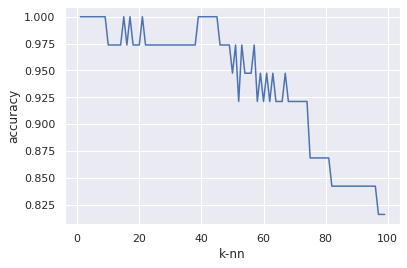

In [26]:
accuracy_list = []
sns.set()
k_range = range(1, 100)
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    Y2_train = np.array(Y_train.Species) #add line
    knn.fit(X_train, Y2_train) #Y_train -> Y2_train
    Y_pred = knn.predict(X_test)
    accuracy_list.append(metrics.accuracy_score(Y_test, Y_pred))

figure = plt.figure()
ax = figure.add_subplot(111)
ax.plot(k_range, accuracy_list)
ax.set_xlabel('k-nn')
ax.set_ylabel('accuracy')
plt.show()

In [27]:
## 回帰問題の実装 ##

import pandas as pd
import seaborn as sns
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [28]:
boston = load_boston()
boston_df = DataFrame(boston.data)
boston_df.columns = boston.feature_names
print(boston_df)
X_train, X_test, Y_train, Y_test = train_test_split(boston_df, boston.target)

        CRIM    ZN  INDUS  CHAS    NOX  ...  RAD    TAX  PTRATIO       B  LSTAT
0    0.00632  18.0   2.31   0.0  0.538  ...  1.0  296.0     15.3  396.90   4.98
1    0.02731   0.0   7.07   0.0  0.469  ...  2.0  242.0     17.8  396.90   9.14
2    0.02729   0.0   7.07   0.0  0.469  ...  2.0  242.0     17.8  392.83   4.03
3    0.03237   0.0   2.18   0.0  0.458  ...  3.0  222.0     18.7  394.63   2.94
4    0.06905   0.0   2.18   0.0  0.458  ...  3.0  222.0     18.7  396.90   5.33
..       ...   ...    ...   ...    ...  ...  ...    ...      ...     ...    ...
501  0.06263   0.0  11.93   0.0  0.573  ...  1.0  273.0     21.0  391.99   9.67
502  0.04527   0.0  11.93   0.0  0.573  ...  1.0  273.0     21.0  396.90   9.08
503  0.06076   0.0  11.93   0.0  0.573  ...  1.0  273.0     21.0  396.90   5.64
504  0.10959   0.0  11.93   0.0  0.573  ...  1.0  273.0     21.0  393.45   6.48
505  0.04741   0.0  11.93   0.0  0.573  ...  1.0  273.0     21.0  396.90   7.88

[506 rows x 13 columns]


In [29]:
knr = KNeighborsRegressor()
knr.fit(X_train, Y_train)
Y_pred = knr.predict(X_test)

mae = mean_absolute_error(Y_test, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

print('平均絶対誤差: ', mae)
print('二乗平均平方根誤差:', rmse)

平均絶対誤差:  5.025354330708662
二乗平均平方根誤差: 7.453341057095525


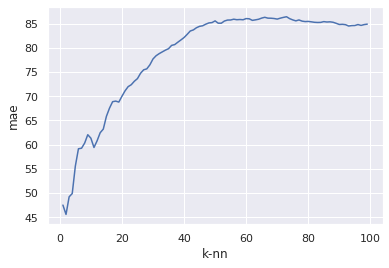

In [30]:
mae_list = []
sns.set()
k_range = range(1, 100)
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    mae_list.append(mean_squared_error(Y_test, Y_pred))

figure = plt.figure()
ax = figure.add_subplot(111)
ax.plot(k_range, mae_list)
ax.set_xlabel('k-nn')
ax.set_ylabel('mae')
plt.show()

In [31]:
# https://www.sejuku.net/blog/64355


import pandas as pd
#データの読み込みや前処理などの機能がまとめられたライブラリ。
#この記事ではデータセットの中身を見るためだけに使っているので、なくてもOKです。

import numpy as np
#計算を行うメインのライブラリ。
#様々な数式の操作に対応した便利な関数があるため、基本的にどんな機械学習モデルの実装でも使います。

import matplotlib.pyplot as plt
#Pythonの可視化ライブラリ。
#Pandasの.plotメソッドだけでも可視化はできます。

from sklearn import datasets
#様々な機械学習モデルの実装が収められたライブラリ。
#データセットをダウンロードして読み込むための関数を使うためにimportしています。

from collections import Counter
#今回k-nnの実装でズルをするために使うライブラリ。
#リストのようなデータ形式の中の要素の数え上げを行う機能が実装されています。


In [32]:
iris = datasets.load_iris()
df = pd.DataFrame(
    iris.data,
    columns = iris.feature_names
)
df["label"] = iris.target

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [33]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,4.9,3.6,1.4,0.1,0
1,5.5,4.2,1.4,0.2,0
2,6.3,2.7,4.9,1.8,2
3,5.5,2.5,4.0,1.3,1
4,5.0,2.3,3.3,1.0,1


In [34]:
train_size = 75
train_data = df.iloc[:train_size].values
test_data = df.iloc[train_size:].values

In [35]:
def knn(k, train_data, test_data):
    labels = []
    
    for test in test_data:
        
        # 1. すべてのトレインデータとtest（このループステップでラベルを予測したいデータ）との距離を計算したリストを作る
        distances = np.sum((train_data[:,:-1]-test[:-1])**2, axis=1)
        
        # 2. 距離リストの値が小さい順に並べた、トレインデータのインデックスを持つリストを作る
        sorted_train_indexes = np.argsort(distances)
        
        # 3. インデックスリストを元に、testから近いk個のトレインデータのラベルを取り出す
        sorted_k_labels = train_data[sorted_train_indexes, -1][:k]
        
        # 4. sorted_k_labelsの中で最も数の多かったlabelを取り出す
        label = Counter(sorted_k_labels).most_common(1)[0][0]
        labels.append(label)
    return labels

In [36]:
pred_labels = knn(2, train_data, test_data)

np.sum(pred_labels == test_data[:,-1]) / len(test_data)

0.96

Text(0.5, 1.0, 'true label')

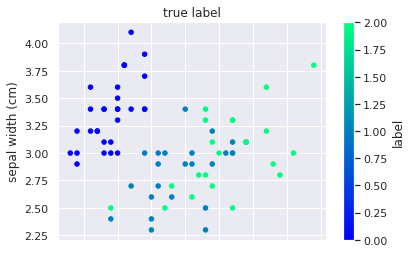

In [37]:
test_df = df.iloc[train_size:].copy()
test_df["pred_label"] = pred_labels
 
test_df.plot(kind="scatter", x=0,y=1,c="label", cmap="winter")
plt.title("true label")

Text(0.5, 1.0, 'prediction label')

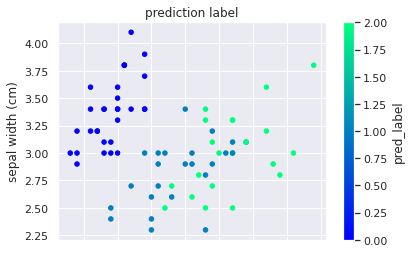

In [38]:
test_df.plot(kind="scatter", x=0,y=1,c="pred_label", cmap="winter")
plt.title("prediction label")

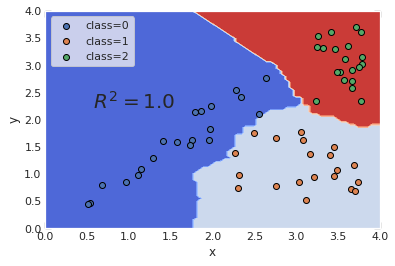

In [41]:
# https://watlab-blog.com/2020/01/12/knn/


import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
 


# データを用意する------------------------------------------
df = pd.DataFrame()                                         # データフレーム初期化
n = 20                                                      # 1クラス毎のデータ数
for i in range(3):                                          # データ作成ループ
    if i == 0:
        x = pd.Series(np.random.uniform(0.5, 2.8, n))
        y = pd.Series(x * np.random.uniform(0.8, 1.2, n))
    elif i == 1:
        x = pd.Series(np.random.uniform(2.2, 3.8, n))
        y = pd.Series(np.random.uniform(0.5, 1.8, n))
    else:
        x = pd.Series(np.random.uniform(3.2, 3.8, n))
        y = pd.Series(np.random.uniform(2.2, 3.8, n))
    label = pd.Series(np.full(n, i))                        # ラベル（クラス）を作成
    temp_df = pd.DataFrame(np.c_[x, y, label])              # クラス毎のデータフレームを作成
    df = pd.concat([df, temp_df])                           # 作成されたクラス毎のデータを逐次結合
df.index = np.arange(0, len(df), 1)                         # index(行ラベル)を初期化
# クラス毎のデータフレームに分離（プロット用）
class_0 = df[df[2] == 0]                                    # ラベル0を抽出
class_1 = df[df[2] == 1]                                    # ラベル1を抽出
class_2 = df[df[2] == 2]                                    # ラベル1を抽出
# ----------------------------------------------------------
 


# 学習させる値(訓練データ)とクラス(正解ラベル)に分離
data = df[[0, 1]]                                           # 訓練データ
data_class = pd.Series(df[2])                               # 正解ラベル
 
# 決定木による学習
clf = KNeighborsClassifier(n_neighbors=5)                   # kNN法オブジェクトを定義
clf.fit(data, data_class)                                   # フィッティング
 
# 決定境界可視化用
grid_line = np.arange(-10, 10, 0.05)                        # グリッドデータのための配列を生成
X, Y = np.meshgrid(grid_line, grid_line)                    # グリッドを作成
Z = clf.predict(np.array([X.ravel(), Y.ravel()]).T)         # .predictが使えるデータshapeに変換して予測
Z = Z.reshape(X.shape)                                      # 3Dプロットするためにshapeを再変換
r2 = clf.score(data, data_class)                            # 決定係数を算出
 


# ここからグラフ描画----------------------------------------
# フォントの種類とサイズを設定する。
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'DejaVu Sans' # Times New Roman はないので DejaVu Sans　に変更した　と表示される
 
# 目盛を内側にする。
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
 
fig = plt.figure()
ax1 = plt.subplot(111)
 
# グラフの上下左右に目盛線を付ける。
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
 
# 軸のラベルを設定する。
ax1.set_xlabel('x')
ax1.set_ylabel('y')
 
# スケールの設定をする。
ax1.set_xlim(0, 4)
ax1.set_ylim(0, 4)
 
# データプロットする。
ax1.contourf(X, Y, Z, cmap='coolwarm')
ax1.scatter(class_0[0], class_0[1], label='class=0', edgecolors='black')
ax1.scatter(class_1[0], class_1[1], label='class=1', edgecolors='black')
ax1.scatter(class_2[0], class_2[1], label='class=2', edgecolors='black')
plt.text(0.5, 2.2, '$\ R^{2}=$' + str(round(r2, 2)), fontsize=20)
 
plt.legend()
 
# グラフを表示する。
plt.show()
plt.close()
# ----------------------------------------------------------

In [ ]:
# https://enjoyworks.jp/tech-blog/227

## k近傍法アルゴリズムをフルスクラッチで実装してみたよ。 ##



In [43]:
## ユークリッド距離 ##

import math

def euclidanDistance(instance1,instance2,lenght):
  distance = 0
  for x in range(lenght):
    distance += pow((instance1[x] - instance2[x]),2)
    return math.sqrt(distance)

data1 = [2,2,2,'a']
data2 = [4,4,4,'b']
distance = euclidanDistance(data1,data2,3)

print('Distance:'  + repr(distance))

Distance:2.0


In [44]:
## もっとも近いデータポイントを返す ##

import operator

def getNeighbors(trainingSet,testInstance,k):
  distance = []
  length = len(testInstance)-1
  
  for x in range(len(trainingSet)):
    dist = euclidanDistance(testInstance,trainingSet[x],length)
    distance.append((trainingSet[x],dist))

  distance.sort(key=operator.itemgetter(1))
  neighbors = []
  
  for x in range(k):
    neighbors.append(distance[x][0])

  return neighbors

In [45]:
trainSet = [[2,2,2,'a'],[4,4,4,'b']]
testInstance = [5,5,5]
k  =1

neighbors = getNeighbors(trainSet,testInstance,1)
print(neighbors)

[[4, 4, 4, 'b']]


In [46]:
## どのクラスに属するか推論する ##

import operator

def getResponse(neighbors):
  classVotes = {}
  for x in range(len(neighbors)):
    response = neighbors[x][-1]
    if response in classVotes:
      classVotes[response] += 1
    else:
      classVotes[response] = 1
  sortedVotes = sorted(classVotes.items(),key=operator.itemgetter(1),reverse=True)

  return sortedVotes[0][0]


#neighbors = [[1,1,1,'a'],[2,2,2,'a'],[3,3,3,'b']]
response = getResponse(neighbors)
print(response)

b


In [48]:
## 精度を計算 ##

def getAccuracy(testSet,predictions):
  correct = 0
  for x in range(len(testSet)):
    if testSet[x][-1] is predictions[x]:
      correct +=1
  return (correct/float(len(testSet)))  * 100.0


testSet = [[1,1,1,'a'],[2,2,2,'a'],[3,3,3,'b']]
predictions = ['a','a','a']
accuracy = getAccuracy(testSet,predictions)

print(accuracy)

66.66666666666666


In [49]:
## 最後に作った関数を１つにしてみましょう ##

def main(trainingSet,testSet):
  print('Train set:' + repr(len(trainingSet)))
  print('Test set:' + repr(len(testSet)))
  predictions = []
  k=1

  for x in range(len(testSet)):
    neighbors = getNeighbors(trainingSet,testSet[x],k)
    result = getResponse(neighbors)
    predictions.append(result)
    print('> predicted=' + repr(result)+ ',actual='+ repr(testSet[x][-1]))

  accuracy = getAccuracy(testSet,predictions)
  print('Accuracy: ' + repr(accuracy)+'%')


trainSet = [[2,2,2,'a'],[4,4,4,'b'],[3,3,3,'c'],[7,7,7,'e']]
testSet =[[8,8,8,'e']]
main(trainSet,testSet)

Train set:4
Test set:1
> predicted='e',actual='e'
Accuracy: 100.0%
